# Experiemental data testing for perturbation for Lotka-Voltera model 

In [204]:
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns 
import cvxpy as cvx
import time
from collections import  defaultdict
import copy

import importlib
import iterative_perturbation
importlib.reload(iterative_perturbation)

from iterative_perturbation import general_perturbation_prediction
from iterative_perturbation import prediction_given_Sbool

In [205]:

def invader_community_prediction(system_before, interaction_matrix):
    invader_bools=[]
    invader_predicted = []
    community_predicted = []

    dressed_invasion_fitnesses=[]
    for species_abundance in system_before:
        # Determine which species are invaders and which survive
        invader_bool = np.logical_not(species_abundance)
        resident_bool = np.logical_not(invader_bool)
        num_survive = np.sum(resident_bool)

        invader_bools.append(invader_bool)
        
        # Construct submatrices for the interaction matrix
        A_SS = -1 * interaction_matrix[resident_bool, :][:, resident_bool]
        A_II = -1 * interaction_matrix[invader_bool, :][:, invader_bool]
        A_SI = -1 * interaction_matrix[resident_bool, :][:, invader_bool]
        A_IS = -1 * interaction_matrix[invader_bool, :][:, resident_bool]

        # Initialize variables for perturbation prediction
        knock_off = np.array([False] * num_survive)
        delta_u = np.zeros(num_survive)
        u = np.ones(num_survive)
        u_I = np.array([1])  # Assuming a single invader
        
        # Call to general_perturbation_prediction (assumed to be defined elsewhere)
        predicted_XList = general_perturbation_prediction(
            A_SS, species_abundance[resident_bool], u, delta_u, knock_off,
            A_II, A_IS, A_SI, u_I, num_iters=50, momentum=0.1,survival_threshold=1e-5
        )
        # print('-A_IS@X+u_I',-A_IS@ species_abundance[resident_bool]+u_I)
        # print('Minv',np.linalg.inv(A_II-A_IS@np.linalg.inv(A_SS)@A_SI))
        # print('-A_IS@X+u_I/Minv',(-A_IS@ species_abundance[resident_bool]+u_I)/np.linalg.inv(A_II-A_IS@np.linalg.inv(A_SS)@A_SI))
        # print('predicted_XList[-1][num_survive:]',predicted_XList[-1][num_survive:])
        # Append predictions for invaders and survivors
        invader_predicted.append(predicted_XList[-1][num_survive:])
        community_predicted.append(predicted_XList[-1][:num_survive])

    # Convert lists to numpy arrays before returning
    invader_predicted = np.array(invader_predicted)
    community_predicted = np.array(community_predicted)

    return invader_predicted, community_predicted, invader_bools


In [206]:
from collections import defaultdict
def filter_arrays_by_zeros(data, zero_count):
    """Filters the input list of numpy arrays based on the number of actual zero elements in each array."""
    return [array for array in data if np.count_nonzero(array == 0) == zero_count]

def group_by_nonzero_elements(arr):
    # Initialize a dictionary to store groups
    groups = defaultdict(list)
    
    # Iterate over each row in the array
    for row in arr:
        # Get the tuple of indices where the row has non-zero elements
        non_zero_tuple = tuple(np.where(row != 0)[0])
        
        # Append the row to the group corresponding to its non-zero pattern
        groups[non_zero_tuple].append(row)
    
    # Return only the groups of rows
    return list(groups.values())

def calculate_group_medians(groups, low_percentile=25, high_percentile=75):
    # Initialize lists to store the medians and percentiles of each group
    group_medians = []
    group_low_percentile = []
    group_high_percentile = []
    
    # Iterate over each group
    for group in groups:
        # Convert the group to a NumPy array for easier calculation
        group_array = np.array(group)
        
        # Append the median to the list
        group_medians.append(np.nanmedian(group_array, axis=0))
        
        # Append the 5th and 95th percentiles to their respective lists
        group_low_percentile.append(np.percentile(group_array, 5, axis=0))
        group_high_percentile.append(np.percentile(group_array, 95, axis=0))

    return np.array(group_medians), np.array(group_low_percentile), np.array(group_high_percentile)

In [207]:
from collections import defaultdict

def get_grouping_indices(arr):
    indices = defaultdict(list)
    
    for i, row in enumerate(arr):
        # Get the tuple of indices where the row has non-zero elements
        non_zero_tuple = tuple(np.where(row != 0)[0])
        indices[non_zero_tuple].append(i)
    
    return indices

def apply_grouping(arr, indices):
    grouped_arr= defaultdict(list)
    
    for non_zero_tuple, row_indices in indices.items():
        for i in row_indices:
            grouped_arr[non_zero_tuple].append(arr[i])
            
    return list(grouped_arr.values())

In [208]:

def process_data_individual(data, B):
 
    # Step 1: Extract system before and after invasion based on position of zeros
    system_before = filter_arrays_by_zeros(data[1:], 1) #get prediction for each individual system
    system_after = filter_arrays_by_zeros(data[1:], 0)

    # Step 2: Perform invader community prediction
    invader_predicted, community_predicted, invader_bools = invader_community_prediction(
        system_before,
        B
    )
    #Step 3: Get median predictions among replicates
    indices = get_grouping_indices(system_before)
    
    invader_bools_arranged=[sublist[0] for sublist in apply_grouping(invader_bools,indices)]
    
    medians_invader_predicted,low_invader_predicted, high_invader_predicted=calculate_group_medians(apply_grouping(invader_predicted,indices))
    medians_community_predicted, low_community_predicted, high_community_predicted=calculate_group_medians(apply_grouping(community_predicted,indices))

    #Step 4: Arrange and calculate statistics of the data 
    system_after_median, system_after_low, system_after_high = calculate_group_medians([system_after])

    medians_invader_data=[]
    low_invader_data=[]
    high_invader_data=[]
    
    medians_community_data=[]
    low_community_data=[]
    high_community_data=[]
    
    for invader_bool in invader_bools_arranged:
        survive_bool=np.logical_not(invader_bool)
        medians_community_data.append(system_after_median[0][survive_bool])
        low_community_data.append(system_after_low[0][survive_bool])
        high_community_data.append(system_after_high[0][survive_bool])
        
        medians_invader_data.append(system_after_median[0][invader_bool])
        low_invader_data.append(system_after_low[0][invader_bool])
        high_invader_data.append(system_after_high[0][invader_bool])

    
    return {
        'invader_data': [medians_invader_data, low_invader_data, high_invader_data],
        'invader_predicted': [medians_invader_predicted, low_invader_predicted, high_invader_predicted],
        'community_data': [medians_community_data, low_community_data, high_community_data],
        'community_predicted': [medians_community_predicted, low_community_predicted, high_community_predicted]
    }

In [209]:
def plot_invader_community(invader_predicted, invader_data, community_predicted, community_data, filename):
    # Set figure dimensions
    figure_width = 3
    fig, ax = plt.subplots(1, 2, figsize=(figure_width * 1.9, figure_width * 1))

    # Scatter plot for invader predicted vs data

    invader_x_point=np.concatenate(invader_predicted[0])
    invader_y_point= np.concatenate(invader_data[0])
    invader_x_error=[invader_x_point-np.concatenate(invader_predicted[1]),np.concatenate(invader_predicted[2])-invader_x_point]
    invader_y_error=[invader_y_point-np.concatenate(invader_data[1]), np.concatenate(invader_data[2])-invader_y_point]
    

    maxX0 = np.max(np.concatenate((invader_predicted[2], invader_data[2])))
    minX0 = np.min(np.concatenate((invader_predicted[1], invader_data[1])))
    
    ax[0].errorbar(np.concatenate(invader_predicted[0]), np.concatenate(invader_data[0]),xerr=invader_x_error, yerr=invader_y_error, markersize=5, alpha=0.3, c='darkgreen', ecolor='gray', ls='', marker='o', capsize=5)

    ax[0].plot([0, maxX0], [0, maxX0], color='r', linestyle='dashed', linewidth=1)
    ax[0].set_xlabel('Prediction')
    ax[0].set_ylabel('Data')
    ax[0].set_xlim(minX0 * 0.3, 1.1 * maxX0)
    ax[0].set_ylim(minX0 * 0.3, 1.1 * maxX0)
    ax[0].set_title('invader')
    ax[0].set_aspect(aspect='equal', adjustable='box')
    ax[0].set_yscale('symlog', linthresh=np.min(invader_data[0]))
    ax[0].set_xscale('symlog', linthresh=np.min(invader_data[0]))
    # Scatter plot for community predicted vs data

    community_x_point=np.concatenate(community_predicted[0])
    community_y_point= np.concatenate(community_data[0])
    community_x_error=[community_x_point-np.concatenate(community_predicted[1]),np.concatenate(community_predicted[2])-community_x_point]
    community_y_error=[community_y_point-np.concatenate(community_data[1]), np.concatenate(community_data[2])-community_y_point]
    maxX = np.max(np.concatenate((community_predicted[2],community_data[2])))
    minX = np.min(np.concatenate((community_predicted[1],community_data[1])))

    ax[1].errorbar(np.concatenate(community_predicted[0]), np.concatenate(community_data[0]),xerr=community_x_error, yerr=community_y_error, markersize=5, alpha=0.3, c='blue', ecolor='gray', ls='', marker='o', capsize=5)
    ax[1].plot([0, maxX], [0, maxX], color='r', linestyle='dashed', linewidth=1)
    ax[1].set_xlabel('Prediction')
    ax[1].set_ylabel('Data')
    ax[1].set_xlim(minX*0.3, 1.1 * maxX)
    ax[1].set_ylim(minX*0.3, 1.1 * maxX)
    ax[1].set_title('community')
    ax[1].set_aspect(aspect='equal', adjustable='box')
    ax[1].set_yscale('symlog', linthresh=np.min(community_data[0]))
    ax[1].set_xscale('symlog', linthresh=np.min(community_data[0]))

    
    # Adjust layout and save the figure
    plt.tight_layout()
    fig.savefig(filename, format="pdf")
    
    # Show the plot
    plt.show()

In [210]:

def get_invasion_fitness_and_dressing(list_system_before, system_after, interaction_matrix):
    invasion_fitnesses=[]
    dressed_invasion_fitnesses=[]
    invader_bools=[]
    for i in range(len(list_system_before)):
        species_abundance=list_system_before[i]

        # Determine which species are invaders and which are resident
        invader_bool = np.logical_not(species_abundance)
        resident_bool = np.logical_not(invader_bool)
        num_survive = np.sum(resident_bool)
        
        # Construct submatrices for the interaction matrix
        A_SS = -1 * interaction_matrix[resident_bool, :][:, resident_bool]
        A_II = -1 * interaction_matrix[invader_bool, :][:, invader_bool]
        A_SI = -1 * interaction_matrix[resident_bool, :][:, invader_bool]
        A_IS = -1 * interaction_matrix[invader_bool, :][:, resident_bool]
       
        # Initialize variables for perturbation prediction
        knock_off = np.array([False] * num_survive)
        delta_u = np.zeros(num_survive)
        u = np.ones(num_survive)
        u_I = np.array([1])  # Assuming a single invader

        # Call to general_perturbation_prediction (assumed to be defined elsewhere)
        Sbool=system_after[resident_bool]>0
        Sbool_I=system_after[invader_bool]>0
      
        _, _, M_inv, invasion_fitness=prediction_given_Sbool(
            A_SS, species_abundance[resident_bool], u, delta_u,
            A_II, A_IS, A_SI, u_I, Sbool, Sbool_I
        )
        
        invasion_fitnesses.append(invasion_fitness)
        invader_bools.append(invader_bool)

        if M_inv[0,0] == 0:
            dressed_invasion_fitnesses.append(0)
        else:
            dressed_invasion_fitnesses.append(invasion_fitness*M_inv[0,0])
    
    invasion_fitnesses=np.array(invasion_fitnesses)
    dressed_invasion_fitnesses=np.array(dressed_invasion_fitnesses)

    return dressed_invasion_fitnesses, invasion_fitnesses, invader_bools
    
def process_data_individual_invasion_fitness(data, B):
    # Step 1: Extract system before and after invasion based on position of zeros
    system_before = filter_arrays_by_zeros(data[1:], 1) #get prediction for each individual system
    system_after = filter_arrays_by_zeros(data[1:], 0)
    #Step 4: Arrange and calculate statistics of the data 
    system_after_median, system_after_low, system_after_high = calculate_group_medians([system_after])
    
   
    # Step 2: Perform invader community prediction
    dressed_invasion_fitnesses, invasion_fitnesses, invader_bools = get_invasion_fitness_and_dressing(
        system_before,
        system_after_median[0],
        B
    )
   
    
    #Step 3: Get median predictions among replicates
    indices = get_grouping_indices(system_before)
    invader_bools_arranged=[sublist[0] for sublist in apply_grouping(invader_bools,indices)]
    
    invasion_fitnesses_arranged = apply_grouping(invasion_fitnesses, indices)
    dressed_invasion_fitnesses_arranged = apply_grouping(dressed_invasion_fitnesses, indices)


    
    medians_dressed_invasion_fitnesses, low_dressed_invasion_fitnesses, high_dressed_invasion_fitnesses = calculate_group_medians(dressed_invasion_fitnesses_arranged)
    medians_invasion_fitnesses, low_invasion_fitnesses, high_invasion_fitnesses = calculate_group_medians(invasion_fitnesses_arranged)

    
    medians_invader_data=[]
    low_invader_data=[]
    high_invader_data=[]
    
    for invader_bool in invader_bools_arranged:
        medians_invader_data.append(system_after_median[0][invader_bool])
        low_invader_data.append(system_after_low[0][invader_bool])
        high_invader_data.append(system_after_high[0][invader_bool])

    
    return {
        'dressed_invasion_fitnesses': [medians_dressed_invasion_fitnesses, low_dressed_invasion_fitnesses, high_dressed_invasion_fitnesses],
        'invader_data': [medians_invader_data, low_invader_data, high_invader_data],
        'invasion_fitnesses': [medians_invasion_fitnesses, low_invasion_fitnesses, high_invasion_fitnesses]
    }

def plot_invader_fitness_abundance(invader_abundance, invasion_fitness, dressed_invasion_fitness, filename,tick_density=1):
    # Set figure dimensions
    figure_width = 2.7
    fig, ax = plt.subplots(1, 2, figsize=(figure_width * 2.5, figure_width * 1))

    # Scatter plot for invasion fitness vs abundance
  
    invader_y_point = np.concatenate(invader_abundance[0])
    
    invader_y_error = [invader_y_point-np.concatenate(invader_abundance[1]), 
                      np.concatenate(invader_abundance[2])-invader_y_point]
    
    fitness_x_point = np.concatenate(invasion_fitness[0])
    fitness_x_error = [fitness_x_point-np.concatenate(invasion_fitness[1]),
                      np.concatenate(invasion_fitness[2])-fitness_x_point]

    maxY = np.max(np.concatenate(invader_abundance[2]))
    minY = np.min(np.concatenate(invader_abundance[1]))
    maxX = np.max(np.concatenate(invasion_fitness[2]))
    minX = np.min(np.concatenate(invasion_fitness[1]))

    ax[0].errorbar(fitness_x_point, invader_y_point, 
                  xerr=fitness_x_error, yerr=invader_y_error,
                  markersize=5, alpha=0.5, c='darkgreen', ecolor='gray',
                  ls='', marker='o', capsize=5)

    
    ax[0].set_xlabel('Invasion Fitness')
    ax[0].set_ylabel('Invader Abundance')
    ax[0].set_xlim(minX * 1.1, maxX * 2)
    ax[0].set_ylim(minY * 0.3, maxY * 2)
    #ax[0].set_title('Invasion Fitness')
    ax[0].set_yscale('symlog', linthresh=np.min(np.abs(invader_y_point[0])))
    ax[0].set_xscale('symlog', linthresh=np.min(np.abs(invasion_fitness[0])))
    # Scatter plot for dressed invasion fitness vs abundance
    dressed_x_point = np.concatenate(dressed_invasion_fitness[0])
    dressed_x_error = [dressed_x_point-np.concatenate(dressed_invasion_fitness[1]),
                      np.concatenate(dressed_invasion_fitness[2])-dressed_x_point]

    maxX = np.max(np.concatenate(dressed_invasion_fitness[2]))
    minX = np.min(np.concatenate(dressed_invasion_fitness[1]))

    ax[1].errorbar(dressed_x_point, invader_y_point,
                  xerr=dressed_x_error, yerr=invader_y_error, 
                  markersize=5, alpha=0.5, c='darkgreen', ecolor='gray',
                  ls='', marker='o', capsize=5)
    
    # Add x=y line
    line_min = min(minX, minY)
    line_max = max(maxX*2, maxY*2) 
    ax[1].plot([line_min, line_max], [line_min, line_max], 'k--', alpha=0.5)
    ax[1].set_xlabel('Dressed Invasion Fitness') 
    ax[1].set_ylabel('Invader Abundance')
    ax[1].set_xlim(minX * 1.1, maxX * 2)
    ax[1].set_ylim(minY * 0.3, maxY * 2)
    #ax[1].set_title('Dressed Invasion Fitness')
    ax[1].set_yscale('symlog', linthresh=np.min(np.abs(invader_y_point[0]))/5)
    ax[1].set_xscale('symlog', linthresh=np.min(np.abs(dressed_x_point[0]))/5)
    # Set ticks to show every power of 10
    
    # for a in ax:
    #     # Get the axis limits
    #     ymin, ymax = a.get_ylim()
    #     xmin, xmax = a.get_xlim()
        
    #     # Generate power of 10 ticks within the range, excluding values above max
    #     yticks = np.array([10**i for i in range(int(np.floor(np.log10(abs(ymin)))), 
    #                                            int(np.ceil(np.log10(abs(ymax)))))])
    #     xticks = np.array([10**i for i in range(int(np.floor(np.log10(abs(xmin)))), 
    #                                            int(np.ceil(np.log10(abs(xmax)))))])
        
    #     # Add negative powers of 10 for negative ranges
    #     if ymin < 0:
    #         yticks = np.concatenate([-yticks[::-1], [0], yticks])
    #     if xmin < 0:    
    #         xticks = np.concatenate([-xticks[::-1], [0], xticks])
            
    #     # Set the new ticks
    #     a.set_yticks(yticks)
    #     a.set_xticks(xticks)
    #Reduce tick density and prevent overlap
    for a in ax:
        # Get current ticks
        yticks = a.get_yticks()
        xticks = a.get_xticks()
        
        # Reduce number of ticks by taking every tick_density th tic
        a.set_yticks(yticks[::tick_density])
        a.set_xticks(xticks[::tick_density])
        
        # Rotate x-axis labels for better readability
        #a.tick_params(axis='x', rotation=45)
    
    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight',format='pdf')






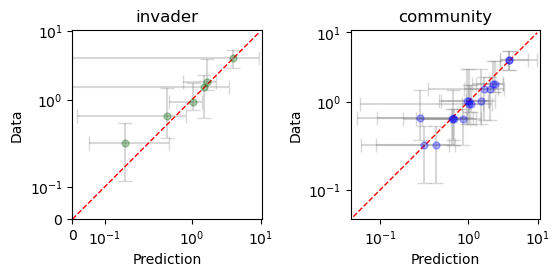

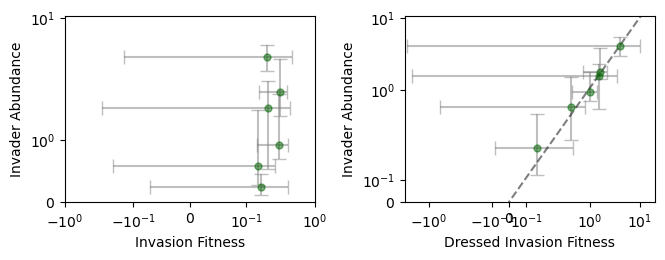

In [211]:
#input data
B_native= np.array([
    [-0.45, -0.05, -0.13, -0.20],
    [-0.28, -0.16, -0.43, -0.18],
    [-0.28, -0.06, -0.96, -0.18],
    [-0.28, -0.04, -0.06, -0.29]
])

B_nonnative = np.array([
    [-0.48, -0.07, -0.15, -0.22],
    [-0.30, -0.10, -0.22, -0.25],
    [-0.34, -0.07, -0.36, -0.23],
    [-0.32, -0.07, -0.21, -0.48]
])

data_natives = np.genfromtxt('data/Kuebbing_plants/natives.csv'
, delimiter=',', dtype=float, encoding='utf-8')


data_nonnatives = np.genfromtxt('data/Kuebbing_plants/invasives.csv'
, delimiter=',', dtype=float, encoding='utf-8')

# Process natives data
natives_processed_data = process_data_individual(data_natives, B_native)

# Process nonnatives data
nonnatives_processed_data = process_data_individual(data_nonnatives, B_nonnative)

# Combine and plot the results
plot_invader_community(
    np.concatenate((natives_processed_data['invader_predicted'], nonnatives_processed_data['invader_predicted']),axis=1),
    np.concatenate((natives_processed_data['invader_data'], nonnatives_processed_data['invader_data']),axis=1),
    np.concatenate((natives_processed_data['community_predicted'], nonnatives_processed_data['community_predicted']),axis=1),
    np.concatenate((natives_processed_data['community_data'], nonnatives_processed_data['community_data']),axis=1),
    'data_combined_plant.pdf'
)
# Process natives data
natives_processed_data_fitness = process_data_individual_invasion_fitness(data_natives, B_native)

# Process nonnatives data
nonnatives_processed_data_fitness = process_data_individual_invasion_fitness(data_nonnatives, B_nonnative)

plot_invader_fitness_abundance(
    np.concatenate([natives_processed_data_fitness['invader_data'], nonnatives_processed_data_fitness['invader_data']],axis=1),
    np.concatenate([natives_processed_data_fitness['invasion_fitnesses'], nonnatives_processed_data_fitness['invasion_fitnesses']],axis=1),
    np.concatenate([natives_processed_data_fitness['dressed_invasion_fitnesses'], nonnatives_processed_data_fitness['dressed_invasion_fitnesses']],axis=1),
    'data_combined_plant_fitness.pdf',tick_density=1)


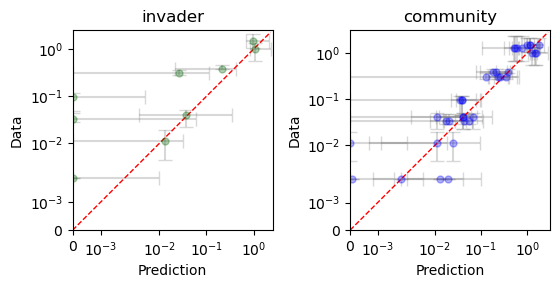

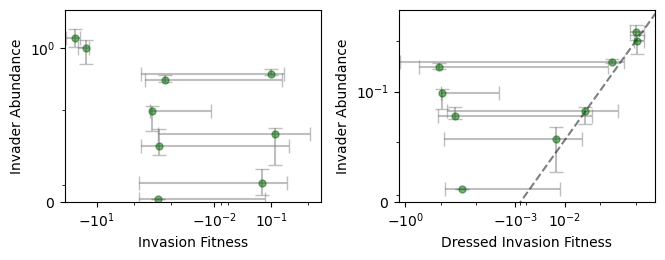

In [212]:
#input data
B_dp_algae= np.array([
    [1.19, -7.66, -6.28, -2.04, -13.23],
    [-0.87, -0.17, -0.38, 2.95, -0.31],
    [-0.81, 4.95, -1.10, 6.95, -0.55],
    [-0.94, 5.66, -0.55, -1.03, -0.59],
    [-1.15, 6.67, 0.09, 10.19, -1.01]
])

B_cd_algae = np.array([
    [3.79, -16.93, -9.70, -1.69, -4.39],
    [-0.61, -0.16, -0.53, 3.39, -0.29],
    [-0.54, 3.38, -0.89, 4.39, -0.51],
    [-0.58, 5.38, -0.52, -1.35, -0.60],
    [-0.57, 4.30, -0.56, 8.92, -0.74]
])

# Use genfromtxt to read the CSV file
data_dp_algae = np.genfromtxt('data/Rakowski_daphnia/dp_algae.csv'
, delimiter=',', dtype=float, encoding='utf-8')

data_cd_algae = np.genfromtxt('data/Rakowski_daphnia/cd_algae.csv'
, delimiter=',', dtype=float, encoding='utf-8')


# Process natives data
dp_algae_processed_data = process_data_individual(data_dp_algae, B_dp_algae)

# Process nonnatives data
cd_algae_processed_data = process_data_individual(data_cd_algae, B_cd_algae)

# Combine and plot the results
plot_invader_community(
    np.concatenate((dp_algae_processed_data['invader_predicted'], cd_algae_processed_data['invader_predicted']),axis=1),
    np.concatenate((dp_algae_processed_data['invader_data'], cd_algae_processed_data['invader_data']),axis=1),
    np.concatenate((dp_algae_processed_data['community_predicted'], cd_algae_processed_data['community_predicted']),axis=1),
    np.concatenate((dp_algae_processed_data['community_data'], cd_algae_processed_data['community_data']),axis=1),
    'data_combined_algae.pdf'
)

# Process natives data
dp_algae_processed_data_fitness = process_data_individual_invasion_fitness(data_dp_algae, B_dp_algae)

# Process nonnatives data
cd_algae_processed_data_fitness = process_data_individual_invasion_fitness(data_cd_algae, B_cd_algae)


plot_invader_fitness_abundance(
    np.concatenate([dp_algae_processed_data_fitness['invader_data'], cd_algae_processed_data_fitness['invader_data']],axis=1),
    np.concatenate([dp_algae_processed_data_fitness['invasion_fitnesses'], cd_algae_processed_data_fitness['invasion_fitnesses']],axis=1),
    np.concatenate([dp_algae_processed_data_fitness['dressed_invasion_fitnesses'], cd_algae_processed_data_fitness['dressed_invasion_fitnesses']],axis=1)  ,
    'data_combined_algae_fitness.pdf',tick_density=3)

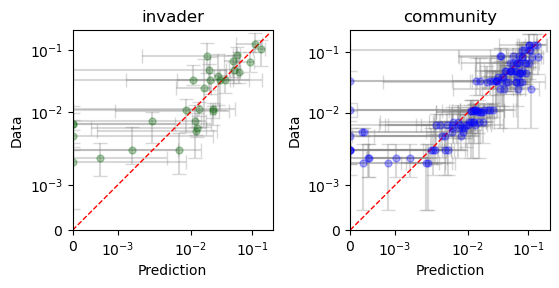

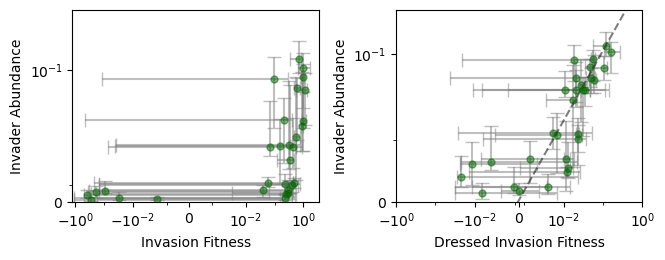

In [213]:
# Define the matrix for 15°C

B_15C = np.array([
    [-8.38, -7.17, 21.21, -5.35, -4.17],
    [-5.27, -22.34, 14.70, -4.46, -6.17],
    [-4.20, -2.30, -14.30, -3.54, -4.73],
    [-3.73, -8.99, 26.05, -8.23, -3.69],
    [-1.42, -6.17, 4.51, -1.73, -14.82]
])

# Define the matrix for 17°C
B_17C = np.array([
    [-8.49, -6.67, 15.41, -5.02, -4.59],
    [-5.24, -26.41, 11.42, -4.60, -5.23],
    [-4.85, -6.45, -10.11, -4.23, -4.42],
    [-2.09, -6.53, -17.57, -8.43, -4.07],
    [0.62, -10.11, 15.37, -1.82, -14.68]
])

# Define the matrix for 19°C
B_19C = np.array([
    [-9.79, -4.28, 18.44, -5.76, -7.23],
    [-6.93, -26.43, 19.31, -5.27, -8.39],
    [-4.35, -9.16, -8.17, -5.15, -5.88],
    [-6.11, 1.63, 25.41, -8.45, -6.57],
    [-0.90, 5.25, 16.84, -2.12, -17.07]
])

# Define the matrix for 21°C
B_21C = np.array([
    [-16.64, -3.36, 13.28, -8.76, -12.80],
    [-11.70, -34.12, 17.19, -8.33, -14.99],
    [-5.48, -9.99, -7.13, -6.81, -11.11],
    [-9.81, 8.72, 19.92, -13.57, -9.44],
    [-9.91, -2.08, 17.63, -6.87, -22.63]
])

# Define the matrix for 23°C
B_23C = np.array([
    [-19.29, -8.92, 12.35, -10.53, -8.77],
    [-11.12, -40.79, 15.27, -10.47, -10.65],
    [-9.33, -14.80, -7.08, -9.87, -8.54],
    [-2.47, 7.36, 30.90, -17.95, -6.54],
    [-1.32, -9.49, 24.06, -7.45, -22.55]
])

# Define the matrix for 25°C
B_25C = np.array([
    [-29.31, -8.71, 4.82, -13.55, -10.00],
    [-15.45, -41.82, 7.47, -13.90, -10.37],
    [-4.88, -22.74, -7.97, -12.28, -8.86],
    [-13.18, 10.41, 8.64, -18.53, -7.50],
    [-21.38, 11.77, 17.92, -14.08, -15.93]
])


# Use genfromtxt to read the CSV file
data_15C = np.genfromtxt('data/Pennekamp_protists/temp_15.csv'
, delimiter=',', dtype=float, encoding='utf-8')
data_17C = np.genfromtxt('data/Pennekamp_protists/temp_17.csv'
, delimiter=',', dtype=float, encoding='utf-8')
data_19C = np.genfromtxt('data/Pennekamp_protists/temp_19.csv'
, delimiter=',', dtype=float, encoding='utf-8')
data_21C = np.genfromtxt('data/Pennekamp_protists/temp_21.csv'
, delimiter=',', dtype=float, encoding='utf-8')
data_23C = np.genfromtxt('data/Pennekamp_protists/temp_23.csv'
, delimiter=',', dtype=float, encoding='utf-8')
data_25C = np.genfromtxt('data/Pennekamp_protists/temp_25.csv'
, delimiter=',', dtype=float, encoding='utf-8')


# Process all dataset 
processed_data_15 = process_data_individual(data_15C, B_15C)
processed_data_17 = process_data_individual(data_17C, B_17C)
processed_data_19 = process_data_individual(data_19C, B_19C)
processed_data_21 = process_data_individual(data_21C, B_21C)
processed_data_23 = process_data_individual(data_23C, B_23C)
processed_data_25 = process_data_individual(data_25C, B_25C)

# Combine and plot the results
plot_invader_community(
    np.concatenate((processed_data_15['invader_predicted'], processed_data_17['invader_predicted'], processed_data_19['invader_predicted'], processed_data_21['invader_predicted'], processed_data_23['invader_predicted'], processed_data_25['invader_predicted']),axis=1),
    np.concatenate((processed_data_15['invader_data'], processed_data_17['invader_data'],processed_data_19['invader_data'],processed_data_21['invader_data'],processed_data_23['invader_data'],processed_data_25['invader_data']),axis=1),
    np.concatenate((processed_data_15['community_predicted'], processed_data_17['community_predicted'], processed_data_19['community_predicted'], processed_data_21['community_predicted'], processed_data_23['community_predicted'], processed_data_25['community_predicted']),axis=1),
    np.concatenate((processed_data_15['community_data'], processed_data_17['community_data'], processed_data_19['community_data'], processed_data_21['community_data'], processed_data_23['community_data'] ,processed_data_25['community_data']),axis=1),
    'data_combined_protist.pdf'
)
# Process invasion fitness for all temperatures
processed_data_15_fitness = process_data_individual_invasion_fitness(data_15C, B_15C)
processed_data_17_fitness = process_data_individual_invasion_fitness(data_17C, B_17C) 
processed_data_19_fitness = process_data_individual_invasion_fitness(data_19C, B_19C)
processed_data_21_fitness = process_data_individual_invasion_fitness(data_21C, B_21C)
processed_data_23_fitness = process_data_individual_invasion_fitness(data_23C, B_23C)
processed_data_25_fitness = process_data_individual_invasion_fitness(data_25C, B_25C)

# Plot invasion fitness vs abundance for all temperatures combined
plot_invader_fitness_abundance(
    np.concatenate([processed_data_15_fitness['invader_data'], 
                   processed_data_17_fitness['invader_data'],
                   processed_data_19_fitness['invader_data'], 
                   processed_data_21_fitness['invader_data'],
                   processed_data_23_fitness['invader_data'],
                   processed_data_25_fitness['invader_data']], axis=1),
    np.concatenate([processed_data_15_fitness['invasion_fitnesses'],
                   processed_data_17_fitness['invasion_fitnesses'],
                   processed_data_19_fitness['invasion_fitnesses'],
                   processed_data_21_fitness['invasion_fitnesses'], 
                   processed_data_23_fitness['invasion_fitnesses'],
                   processed_data_25_fitness['invasion_fitnesses']], axis=1),
    np.concatenate([processed_data_15_fitness['dressed_invasion_fitnesses'],
                   processed_data_17_fitness['dressed_invasion_fitnesses'],
                   processed_data_19_fitness['dressed_invasion_fitnesses'],
                   processed_data_21_fitness['dressed_invasion_fitnesses'],
                   processed_data_23_fitness['dressed_invasion_fitnesses'],
                   processed_data_25_fitness['dressed_invasion_fitnesses']], axis=1),
    'data_combined_protist_fitness.pdf',tick_density=2)


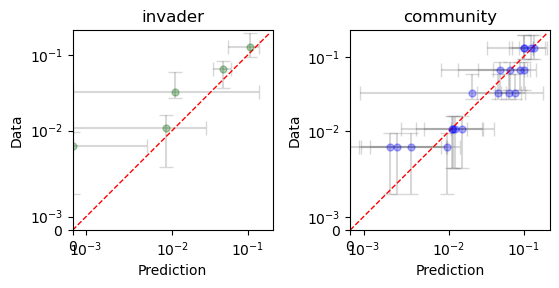

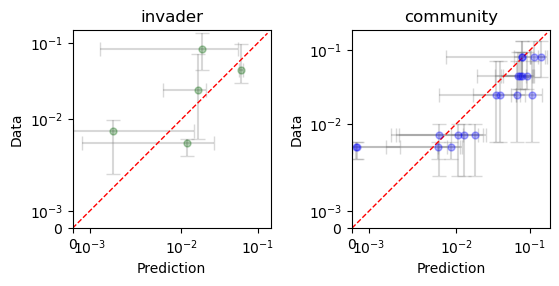

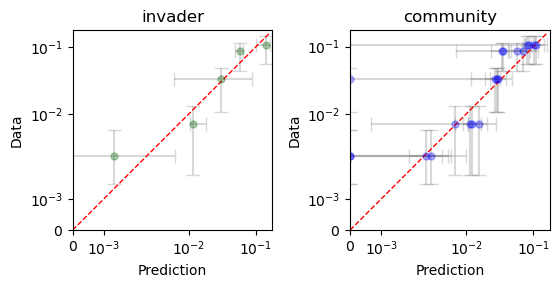

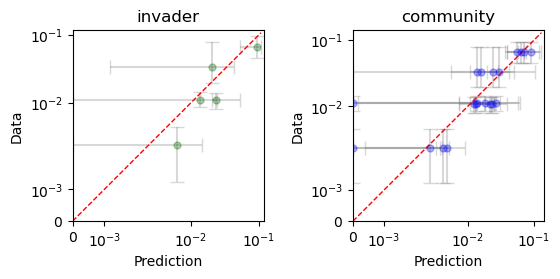

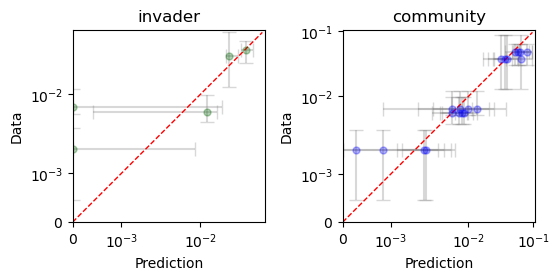

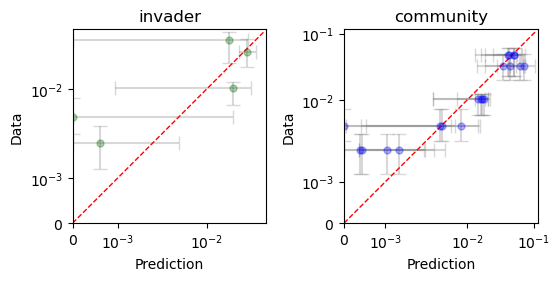

In [214]:
alldata=[processed_data_15, processed_data_17, processed_data_19, processed_data_21, processed_data_23, processed_data_25]

temp=15
for processed_data in alldata:    
    plot_invader_community(
        processed_data['invader_predicted'],
        processed_data['invader_data'],
        processed_data['community_predicted'],
        processed_data['community_data'],
        'Temperature'+str(temp)+'.pdf'
    )
    temp+=2



In [215]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import glob
import os

import os
import glob
import numpy as np
import pandas as pd


def build_B(pars, V, modelnum):
    """
    Constructs the interaction matrix B as in the Stan code.
    
    Parameters:
        pars (np.ndarray): 1D array of parameters.
        V (np.ndarray): The tree matrix (m x n).
        modelnum (int): Model number (1, 2, 3, or 4).
        
    Returns:
        np.ndarray: The interaction matrix B (n x n).
    """
    n = V.shape[1]  # number of species
    m = V.shape[0]  # number of nodes
    np_ = len(pars)

    # Extract lambda (branch lengths)
    lambda_ = np.abs(pars[:m])

    # Model 1: Only lambda, identity for gamma and theta
    if modelnum == 1:
        Gamma = np.eye(n)
        Theta = np.eye(n)
    # Model 2: lambda and gamma, theta is identity
    elif modelnum == 2:
        gamma = np.abs(pars[m:np_-1])
        gamma = n * gamma / np.sum(gamma)
        Gamma = np.diag(gamma)
        Theta = np.eye(n)
    # Model 3: lambda and theta, gamma is identity
    elif modelnum == 3:
        theta = np.abs(pars[m:np_-1])
        theta = n * theta / np.sum(theta)
        Theta = np.diag(theta)
        Gamma = np.eye(n)
    # Model 4: lambda, gamma, and theta
    elif modelnum == 4:
        gamma = np.abs(pars[m:m+n])
        gamma = n * gamma / np.sum(gamma)
        Gamma = np.diag(gamma)
        theta = np.abs(pars[m+n:m+2*n])
        theta = n * theta / np.sum(theta)
        Theta = np.diag(theta)
    else:
        raise ValueError("modelnum must be 1, 2, 3, or 4.")

    L = np.diag(lambda_)
    # Note: V.T is the transpose of V
    B = Gamma @ V.T @ L @ V @ Theta
    return B


def load_data(data_dir):
    # Dictionary to store all data files
    data_dict = {}

    # Get all CSV files in the directory
    csv_files = glob.glob(os.path.join(data_dir, '*.csv'))
    # Filter out files ending with '_V'
    csv_files = [f for f in csv_files if not os.path.basename(f).endswith('_V.csv')]

    # Load each CSV file into the dictionary
    for file_path in csv_files:
        # Get filename without extension as key
        key = os.path.basename(file_path).replace('.csv', '')
        # Read CSV file
        data_dict[key] = np.array(pd.read_csv(file_path))
        
    return data_dict

def load_matrix(matrix_dir):
    # Dictionary to store all matrix data
    matrix_dict = {}

    # Get all RData files in the directory
    rdata_files = glob.glob(os.path.join(matrix_dir, '*.RData'))

    # Load each RData file into the dictionary
    for file_path in rdata_files:
        # Get filename without extension as key
        key = os.path.basename(file_path).replace('.RData', '')
        
        # Load R data file using rpy2
        pandas2ri.activate()
        rdata = robjects.r['load'](file_path)
        
        # Get the data from the R environment and convert to dictionary
        results = robjects.globalenv['results']
        r_list_vector = results
        matrix_parameters_dict = dict(zip(r_list_vector.names, r_list_vector))
        matrix=build_B(matrix_parameters_dict['pars_orig'],np.array(matrix_parameters_dict['V']),matrix_parameters_dict['modelnum'])
        matrix_dict[key]=matrix
        
    return matrix_dict

In [216]:
def find_similar_ecosystem_pairs(data_test, similarity_threshold=0.7):
    """
    Find all pairs of ecosystems with similarity above threshold but not identical presence/absence patterns.
    
    Parameters:
        data_test: numpy array of species abundance data
        similarity_threshold: float between 0 and 1, minimum similarity score to include a pair
        
    Returns:
        similar_pairs: list of tuples, each containing (species_before, species_after, similarity_score)
                      where species_before has fewer presences than species_after
    """
    # Convert data to boolean presence/absence
    data_test_bool = data_test > 0
    
    # Calculate similarity ratio for each pair of ecosystems
    n = len(data_test_bool)
    similarity_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            both_present = np.sum((data_test_bool[i] == 1) & (data_test_bool[j] == 1))
            only_i = np.sum((data_test_bool[i] == 1) & (data_test_bool[j] == 0))
            only_j = np.sum((data_test_bool[i] == 0) & (data_test_bool[j] == 1))
            
            # Calculate ratio of shared species over total changed species
            total = both_present + only_i + only_j
            similarity_matrix[i,j] = both_present / total if total > 0 else 0
    
    # Create mask for diagonal and identical patterns
    mask = np.ones((n, n), dtype=bool)
    
    # Exclude diagonal elements
    np.fill_diagonal(mask, False)
    
    # Exclude patterns with similarity of 1
    for i in range(n):
        for j in range(i+1, n):
            if similarity_matrix[i,j] == 1:
                mask[i,j] = mask[j,i] = False
                
    # Apply mask and threshold to similarity matrix
    masked_similarity = np.where(mask & (similarity_matrix >= similarity_threshold), 
                               similarity_matrix, -np.inf)
    
    # Find all pairs above threshold
    similar_pairs = []
    indices = np.argwhere(masked_similarity > -np.inf)
    
    for i, j in indices:
        # Count number of True values for each species
        count_i = np.sum(data_test_bool[i])
        count_j = np.sum(data_test_bool[j])
        
        # Assign species based on number of presences
        if count_i > count_j:
            species_after = data_test[i]
            species_before = data_test[j]
        else:
            species_after = data_test[j]
            species_before = data_test[i]
            
        similar_pairs.append((species_before, species_after, similarity_matrix[i,j]))
        
    return similar_pairs



In [217]:
def determine_invader_knockoff(species_before, species_after):
    """
    Determine which species are invaders and which are knocked off by comparing
    presence/absence patterns before and after.
    
    Parameters:
        species_before: abundance vector before invasion
        species_after: abundance vector after invasion
        
    Returns:
        invader_bool: boolean array indicating invader species (present after but not before)
        knock_off: boolean array indicating knocked off species (present before but not after)
    """
    # Convert to boolean presence/absence
    present_before = species_before > 0
    present_after = species_after > 0
    
    # Species present after but not before are invaders
    invader_bool = np.logical_and(present_after, np.logical_not(present_before))
    
    # Species present before but not after are knocked off
    knock_off = np.logical_and(present_before, np.logical_not(present_after))
    #knock_off = np.zeros_like(present_before, dtype=bool)
    return invader_bool, knock_off


def invader_community_prediction(species_before, interaction_matrix, invader_bool, knock_off):
    # Determine which species survive
    survive_bool = np.logical_and(species_before > 0, np.logical_not(knock_off))
    num_survive = np.sum(survive_bool)
    num_invader = np.sum(invader_bool)
    # Construct submatrices for the interaction matrix
    A_SS =  interaction_matrix[survive_bool, :][:, survive_bool]
    A_II =  interaction_matrix[invader_bool, :][:, invader_bool]
    A_SI =  interaction_matrix[survive_bool, :][:, invader_bool]
    A_IS =  interaction_matrix[invader_bool, :][:, survive_bool]
    
    # Initialize dummy variables for perturbation prediction
    delta_u = np.zeros(num_survive)
    u = np.ones(num_survive)
    u_I = np.ones(num_invader)  # Assuming a single invader

    # Call to general_perturbation_prediction
    predicted_XList = general_perturbation_prediction(
        A_SS, species_before[survive_bool], u, delta_u, knock_off[survive_bool],
        A_II, A_IS, A_SI, u_I, num_iters=50, momentum=0.1,survival_threshold=5e-1
    )

    # Get final predictions for invaders and survivors
    invader_predicted = predicted_XList[-1][-num_invader:]
    community_predicted = predicted_XList[-1][:-num_invader]

    return invader_predicted, community_predicted


def predict_invasion_for_matrix(matrix_num, data_dict, matrix_dict,no_knock_off=False,similarity_threshold=0.8):
    """
    Make invasion predictions using a specific matrix number for all data
    
    Args:
        matrix_num: integer 1-4 specifying which interaction matrix to use
        data_dict: dictionary containing species abundance data
        matrix_dict: dictionary containing interaction matrices
        
    Returns:
        tuple of lists (community_predicted_all, community_data_all, 
                       invader_predicted_all, invader_data_all)
    """
    community_predicted_all = []
    community_data_all = []
    invader_predicted_all = []
    invader_data_all = []
    similarity_scores =[]
    for key in data_dict.keys():
        data_test = data_dict[key]
        # Find similar ecosystem pairs and get similarity scores
        similar_pairs = find_similar_ecosystem_pairs(data_test,similarity_threshold)
        
        # Process each similar pair
        for species_before, species_after, similarity_score in similar_pairs:
            invader_bool, knock_off = determine_invader_knockoff(species_before, species_after)
            if no_knock_off: knock_off=np.zeros_like(invader_bool, dtype=bool)
            survival_bool = (species_before > 0) & np.logical_not(invader_bool) & np.logical_not(knock_off)
            
            interaction_matrix = matrix_dict[key + f'_{matrix_num}']
            invader_predicted, community_predicted = invader_community_prediction(species_before, interaction_matrix, invader_bool, knock_off)
           
            invader_data = species_after[invader_bool]
            community_data = species_after[survival_bool]
            
            
            # Append values to lists
            community_predicted_all.append(community_predicted)
            community_data_all.append(community_data)
            invader_predicted_all.append(invader_predicted)
            invader_data_all.append(invader_data)
            similarity_scores.append(similarity_score)

        
    return community_predicted_all, community_data_all, invader_predicted_all, invader_data_all, similarity_scores


In [218]:

def get_invasion_fitness_and_dressing(list_system_before, system_after, interaction_matrix):
    invasion_fitnesses=[]
    dressed_invasion_fitnesses=[]
    invader_bools=[]
    for i in range(len(list_system_before)):
        species_abundance=list_system_before[i]

        # Determine which species are invaders and which are resident
        invader_bool = np.logical_not(species_abundance)
        resident_bool = np.logical_not(invader_bool)
        num_survive = np.sum(resident_bool)
        
        # Construct submatrices for the interaction matrix
        A_SS = -1 * interaction_matrix[resident_bool, :][:, resident_bool]
        A_II = -1 * interaction_matrix[invader_bool, :][:, invader_bool]
        A_SI = -1 * interaction_matrix[resident_bool, :][:, invader_bool]
        A_IS = -1 * interaction_matrix[invader_bool, :][:, resident_bool]
       
        # Initialize variables for perturbation prediction
        knock_off = np.array([False] * num_survive)
        delta_u = np.zeros(num_survive)
        u = np.ones(num_survive)
        u_I = np.array([1])  # Assuming a single invader

        # Call to general_perturbation_prediction (assumed to be defined elsewhere)
        Sbool=system_after[resident_bool]>0
        Sbool_I=system_after[invader_bool]>0
      
        _, _, M_inv, invasion_fitness=prediction_given_Sbool(
            A_SS, species_abundance[resident_bool], u, delta_u,
            A_II, A_IS, A_SI, u_I, Sbool, Sbool_I
        )
        
        invasion_fitnesses.append(invasion_fitness)
        invader_bools.append(invader_bool)

        if M_inv[0,0] == 0:
            dressed_invasion_fitnesses.append(0)
        else:
            dressed_invasion_fitnesses.append(invasion_fitness*M_inv[0,0])
    
    invasion_fitnesses=np.array(invasion_fitnesses)
    dressed_invasion_fitnesses=np.array(dressed_invasion_fitnesses)

    return dressed_invasion_fitnesses, invasion_fitnesses, invader_bools
    
def process_data_individual_invasion_fitness(data, B):
    # Step 1: Extract system before and after invasion based on position of zeros
    system_before = filter_arrays_by_zeros(data[1:], 1) #get prediction for each individual system
    system_after = filter_arrays_by_zeros(data[1:], 0)
    #Step 4: Arrange and calculate statistics of the data 
    system_after_median, system_after_low, system_after_high = calculate_group_medians([system_after])
    
   
    # Step 2: Perform invader community prediction
    dressed_invasion_fitnesses, invasion_fitnesses, invader_bools = get_invasion_fitness_and_dressing(
        system_before,
        system_after_median[0],
        B
    )
   
    
    #Step 3: Get median predictions among replicates
    indices = get_grouping_indices(system_before)
    invader_bools_arranged=[sublist[0] for sublist in apply_grouping(invader_bools,indices)]
    
    invasion_fitnesses_arranged = apply_grouping(invasion_fitnesses, indices)
    dressed_invasion_fitnesses_arranged = apply_grouping(dressed_invasion_fitnesses, indices)


    
    medians_dressed_invasion_fitnesses, low_dressed_invasion_fitnesses, high_dressed_invasion_fitnesses = calculate_group_medians(dressed_invasion_fitnesses_arranged)
    medians_invasion_fitnesses, low_invasion_fitnesses, high_invasion_fitnesses = calculate_group_medians(invasion_fitnesses_arranged)

    
    medians_invader_data=[]
    low_invader_data=[]
    high_invader_data=[]
    
    for invader_bool in invader_bools_arranged:
        medians_invader_data.append(system_after_median[0][invader_bool])
        low_invader_data.append(system_after_low[0][invader_bool])
        high_invader_data.append(system_after_high[0][invader_bool])

    
    return {
        'dressed_invasion_fitnesses': [medians_dressed_invasion_fitnesses, low_dressed_invasion_fitnesses, high_dressed_invasion_fitnesses],
        'invader_data': [medians_invader_data, low_invader_data, high_invader_data],
        'invasion_fitnesses': [medians_invasion_fitnesses, low_invasion_fitnesses, high_invasion_fitnesses]
    }



def get_dressed_invasion_fitness(species_before, species_after, interaction_matrix, invader_bool, knock_off):
    # Determine which species survive
    resident_bool = np.logical_and(species_before > 0, np.logical_not(knock_off))
    num_survive = np.sum(resident_bool)
    num_invader = np.sum(invader_bool)
    # Construct submatrices for the interaction matrix
    A_SS =  interaction_matrix[resident_bool, :][:, resident_bool]
    A_II =  interaction_matrix[invader_bool, :][:, invader_bool]
    A_SI =  interaction_matrix[resident_bool, :][:, invader_bool]
    A_IS =  interaction_matrix[invader_bool, :][:, resident_bool]
    
    # Initialize dummy variables for perturbation prediction
    delta_u = np.zeros(num_survive)
    u = np.ones(num_survive)
    u_I = np.ones(num_invader)  # Assuming a single invader

    # Call to general_perturbation_prediction
    predicted_XList = general_perturbation_prediction(
        A_SS, species_before[resident_bool], u, delta_u, knock_off[resident_bool],
        A_II, A_IS, A_SI, u_I, num_iters=50, momentum=0.1,survival_threshold=5e-1
    )
    Sbool=species_after[resident_bool]>0
    Sbool_I=species_after[invader_bool]>0
    
    _, _, M_inv, invasion_fitness=prediction_given_Sbool(
        A_SS, species_before[resident_bool], u, delta_u,
        A_II, A_IS, A_SI, u_I, Sbool, Sbool_I
    ) 
        
    return invasion_fitness, M_inv@invasion_fitness


def get_fitness_for_matrix(matrix_num, data_dict, matrix_dict,no_knock_off=False,similarity_threshold=0.8):
    """
    Make invasion predictions using a specific matrix number for all data
    
    Args:
        matrix_num: integer 1-4 specifying which interaction matrix to use
        data_dict: dictionary containing species abundance data
        matrix_dict: dictionary containing interaction matrices
        
    Returns:
        tuple of lists (community_predicted_all, community_data_all, 
                       invader_predicted_all, invader_data_all)
    """
    invader_data_all = []
    similarity_scores =[]
    invasion_fitnesses_all = []
    dressed_invasion_fitnesses_all = []
    for key in data_dict.keys():
        data_test = data_dict[key]
        # Find similar ecosystem pairs and get similarity scores
        similar_pairs = find_similar_ecosystem_pairs(data_test,similarity_threshold)
        
        # Process each similar pair
        for species_before, species_after, similarity_score in similar_pairs:
            invader_bool, knock_off = determine_invader_knockoff(species_before, species_after)
            if no_knock_off: knock_off=np.zeros_like(invader_bool, dtype=bool)
   
            interaction_matrix = matrix_dict[key + f'_{matrix_num}']
            invasion_fitness, dressed_invasion_fitness = get_dressed_invasion_fitness(species_before, species_after, interaction_matrix, invader_bool, knock_off)
           
            invader_data = species_after[invader_bool]
            
            # Append values to lists
            invader_data_all.append(invader_data)
            similarity_scores.append(similarity_score)
            invasion_fitnesses_all.append(invasion_fitness)
            dressed_invasion_fitnesses_all.append(dressed_invasion_fitness)

        
    return  invader_data_all, similarity_scores, invasion_fitnesses_all, dressed_invasion_fitnesses_all



In [219]:
def plot_invader_community_with_similarity(invader_predicted_list, invader_data_list, community_predicted_list, community_data_list, similarity_score, filename):
    import numpy as np
    import matplotlib.pyplot as plt

    figure_width = 3
    fig, ax = plt.subplots(1, 2, figsize=(figure_width * 1.9, figure_width * 1))

    # Concatenate all arrays
    invader_predicted_all = np.concatenate(invader_predicted_list)
    invader_data_all = np.concatenate(invader_data_list)
    community_predicted_all = np.concatenate(community_predicted_list)
    community_data_all = np.concatenate(community_data_list)

    # Create color arrays
    invader_colors = np.concatenate([np.full(len(arr), score) for arr, score in zip(invader_predicted_list, similarity_score)])
    community_colors = np.concatenate([np.full(len(arr), score) for arr, score in zip(community_predicted_list, similarity_score)])

    # Sort data points by similarity score (ascending) so lower scores are plotted first
    invader_sort_idx = np.argsort(invader_colors)
    community_sort_idx = np.argsort(community_colors)
    
    invader_predicted_all = invader_predicted_all[invader_sort_idx]
    invader_data_all = invader_data_all[invader_sort_idx] 
    invader_colors = invader_colors[invader_sort_idx]
    
    community_predicted_all = community_predicted_all[community_sort_idx]
    community_data_all = community_data_all[community_sort_idx]
    community_colors = community_colors[community_sort_idx]
    # Plot all points in one call per axis
    scatter0 = ax[0].scatter(invader_predicted_all, invader_data_all, s=1, alpha=0.5, c=invader_colors, marker='o', vmin=0.5, vmax=1)
    scatter1 = ax[1].scatter(community_predicted_all, community_data_all, s=1, alpha=0.5, c=community_colors, marker='o', vmin=0.5, vmax=1)

    # Plot diagonal lines
    maxX0 = np.max(np.concatenate((invader_predicted_all, invader_data_all)))
    minX0 = np.min(np.concatenate((invader_predicted_all, invader_data_all)))
    maxX = np.max(np.concatenate((community_predicted_all, community_data_all)))
    minX = np.min(np.concatenate((community_predicted_all, community_data_all)))
    ax[0].plot([0, maxX0], [0, maxX0], color='r', linestyle='dashed', linewidth=1)
    ax[1].plot([0, maxX], [0, maxX], color='r', linestyle='dashed', linewidth=1)

    # Set labels, titles, aspect
    for a in ax:
        a.set_xlabel('Prediction')
        a.set_ylabel('Experiment')
        a.set_aspect(aspect='equal', adjustable='box')
    ax[0].set_title('Invader')
    ax[1].set_title('Community')

    # Set axis limits
    ax[0].set_xlim(minX0, 2 * maxX0)
    ax[0].set_ylim(minX0, 2 * maxX0)
    ax[1].set_xlim(minX, 2 * maxX)
    ax[1].set_ylim(minX, 2 * maxX)

    # Set scales
    min_nonzero_invader = min(
        np.min(invader_predicted_all[invader_predicted_all > 0]),
        np.min(invader_data_all[invader_data_all > 0])
    )
    min_nonzero_community = np.min(community_data_all[community_data_all > 0])
    ax[0].set_yscale('symlog', linthresh=3 * min_nonzero_invader)
    ax[0].set_xscale('symlog', linthresh=3 * min_nonzero_invader)
    ax[1].set_yscale('symlog', linthresh=min_nonzero_community)
    ax[1].set_xscale('symlog', linthresh=min_nonzero_community)

    # Add colorbar
    #plt.colorbar(scatter0, ax=ax, label='Similarity Score', location='right', pad=0.1)
    # Create a new figure for the colorbar
    cbar_fig = plt.figure(figsize=(1, 3))
    cbar_ax = cbar_fig.add_axes([0.2, 0.1, 0.2, 0.8])
    plt.colorbar(scatter0, cax=cbar_ax, label='Similarity Score')
    cbar_fig.savefig('colorbar.pdf', format="pdf", bbox_inches='tight')
    plt.close(cbar_fig)

    plt.tight_layout()
    fig.savefig(filename, format="pdf")
    plt.show()


In [220]:
def plot_invader_community_one_invader_no_inset(invader_predicted_list, invader_data_list, community_predicted_list, community_data_list, similarity_score, filename):
    """Same as plot_invader_community_one_invader but without inset plots"""
    
    figure_width = 2.9
    fig, ax = plt.subplots(1, 2, figsize=(figure_width * 1.9, figure_width * 1))

    # Filter for cases with exactly one invader
    filtered_indices = []
    for i, invader_data in enumerate(invader_data_list):
        if np.sum(invader_data > 0) == 1:  # Count number of non-zero invaders
            filtered_indices.append(i)

    # Filter all lists to only include cases with one invader
    invader_predicted_list = [invader_predicted_list[i] for i in filtered_indices]
    invader_data_list = [invader_data_list[i] for i in filtered_indices]
    community_predicted_list = [community_predicted_list[i] for i in filtered_indices]
    community_data_list = [community_data_list[i] for i in filtered_indices]
    similarity_score = [similarity_score[i] for i in filtered_indices]

    # Concatenate all arrays
    invader_predicted_all = np.concatenate(invader_predicted_list)
    invader_data_all = np.concatenate(invader_data_list)
    community_predicted_all = np.concatenate(community_predicted_list)
    community_data_all = np.concatenate(community_data_list)

    # Create color arrays
    invader_colors = np.concatenate([np.full(len(arr), score) for arr, score in zip(invader_predicted_list, similarity_score)])
    community_colors = np.concatenate([np.full(len(arr), score) for arr, score in zip(community_predicted_list, similarity_score)])

    # Sort data points by similarity score (ascending) so lower scores are plotted first
    invader_sort_idx = np.argsort(invader_colors)
    community_sort_idx = np.argsort(community_colors)
    
    invader_predicted_all = invader_predicted_all[invader_sort_idx]
    invader_data_all = invader_data_all[invader_sort_idx] 
    invader_colors = invader_colors[invader_sort_idx]
    
    community_predicted_all = community_predicted_all[community_sort_idx]
    community_data_all = community_data_all[community_sort_idx]
    community_colors = community_colors[community_sort_idx]
    
    # Plot all points in one call per axis
    scatter0 = ax[0].scatter(invader_predicted_all, invader_data_all, s=24, alpha=0.2, c='darkgreen', marker='o', edgecolors='darkgreen', linewidth=0.5)
    scatter1 = ax[1].scatter(community_predicted_all, community_data_all, s=24, alpha=0.2, c='blue', marker='o', edgecolors='blue', linewidth=0.5)

    # Plot diagonal lines
    maxX0 = 2*np.max(np.concatenate((invader_predicted_all, invader_data_all)))
    minX0 = np.min(np.concatenate((invader_predicted_all, invader_data_all)))
    maxX = 2*np.max(np.concatenate((community_predicted_all, community_data_all)))
    minX = np.min(np.concatenate((community_predicted_all, community_data_all)))
    ax[0].plot([0, maxX0], [0, maxX0], color='r', linestyle='dashed', linewidth=1)
    ax[1].plot([0, maxX], [0, maxX], color='r', linestyle='dashed', linewidth=1)

    # Set labels, titles, aspect
    for a in ax:
        a.set_xlabel('Prediction')
        a.set_ylabel('Experiment')
        a.set_aspect(aspect='equal', adjustable='box')


    # Set axis limits
    ax[0].set_xlim(minX0,   maxX0)
    ax[0].set_ylim(minX0,  maxX0)
    ax[1].set_xlim(minX, maxX)
    ax[1].set_ylim(minX,  maxX)

    # Set scales
    min_nonzero_invader = min(
        np.min(invader_predicted_all[invader_predicted_all > 0]),
        np.min(invader_data_all[invader_data_all > 0])
    )
    min_nonzero_community = np.min(community_data_all[community_data_all > 0])
    ax[0].set_yscale('symlog', linthresh=3 * min_nonzero_invader)
    ax[0].set_xscale('symlog', linthresh=3 * min_nonzero_invader)
    ax[1].set_yscale('symlog', linthresh=min_nonzero_community)
    ax[1].set_xscale('symlog', linthresh=min_nonzero_community)

    plt.tight_layout()
    fig.savefig(filename, format="pdf")
    plt.show()


In [221]:
def plot_invader_fitness_abundance(invader_abundance, invasion_fitness, dressed_invasion_fitness, filename):
    """Plot invader abundance vs invasion fitness and dressed invasion fitness"""
    
    figure_width = 2.6
    fig, ax = plt.subplots(1, 2, figsize=(figure_width * 2.5, figure_width * 1))

    # Plot abundance vs invasion fitness
    scatter0 = ax[0].scatter(invasion_fitness, invader_abundance, s=24, alpha=0.2, c='darkgreen', marker='o', edgecolors='black', linewidth=0.5)
    
    # Plot abundance vs dressed invasion fitness  
    scatter1 = ax[1].scatter(dressed_invasion_fitness, invader_abundance, s=24, alpha=0.2, c='darkgreen', marker='o', edgecolors='black', linewidth=0.5)
    # Add x=y line for both plots
    max_val = max(max(np.abs(invasion_fitness)), max(np.abs(dressed_invasion_fitness)))
    min_val = -max_val
    
    #ax[1].plot([min_val, max_val], [min_val, max_val],alpha=0.5, linestyle='dashed', linewidth=1)
    ax[1].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

    # Set labels, titles
    ax[0].set_xlabel('Invasion Fitness')
    ax[1].set_xlabel('Dressed Invasion Fitness')
    ax[0].set_ylabel('Invader Abundance')
    ax[1].set_ylabel('Invader Abundance')
    

    # Set scales to symlog
    for a in ax:
        a.set_yscale('symlog', linthresh=3 * np.min(np.abs(invader_abundance)))
        a.set_xscale('symlog', linthresh=3 * np.min(np.abs(invasion_fitness)))
    # Reduce tick density and prevent overlap
    for a in ax:
        # Get current ticks
        yticks = a.get_yticks()
        xticks = a.get_xticks()
        
        # Reduce number of ticks by taking every nth tick
        n = 2  # Adjust this value to control tick density
        a.set_yticks(yticks[::n])
        a.set_xticks(xticks[::n])
        
        # Rotate x-axis labels for better readability
        #a.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    fig.savefig(filename, format="pdf")
    plt.show()

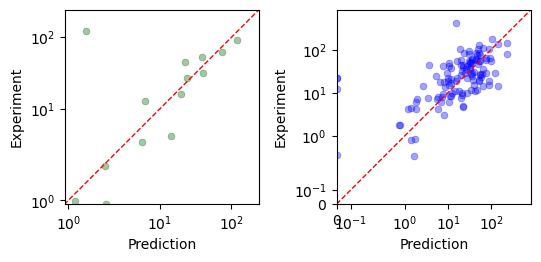

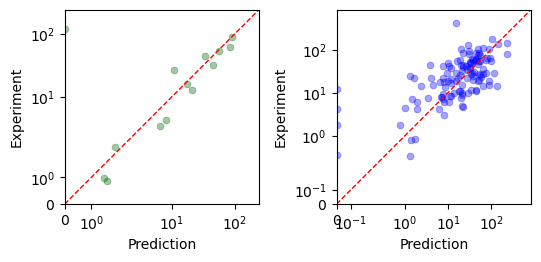

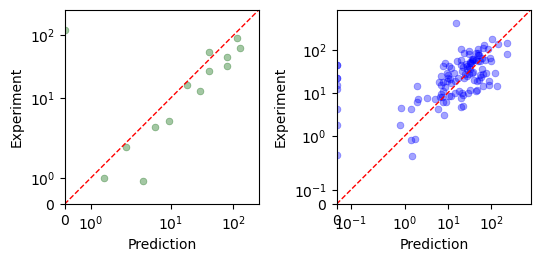

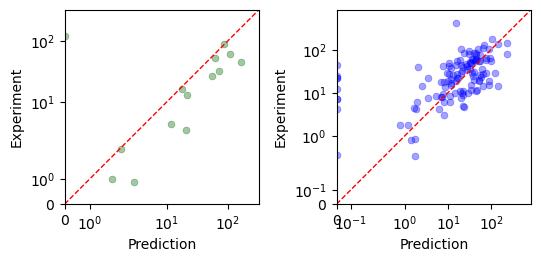

/var/folders/cv/1ryyrfz53_7g9k2dn5pwmtt40000gn/T/ipykernel_15462/303683615.py:71: UserWarning: Adding colorbar to a different Figure <Figure size 570x300 with 2 Axes> than <Figure size 100x300 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter0, cax=cbar_ax, label='Similarity Score')


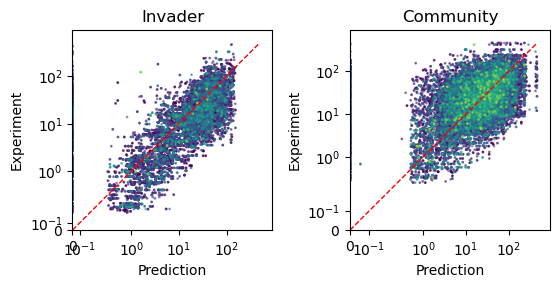

/var/folders/cv/1ryyrfz53_7g9k2dn5pwmtt40000gn/T/ipykernel_15462/303683615.py:71: UserWarning: Adding colorbar to a different Figure <Figure size 570x300 with 2 Axes> than <Figure size 100x300 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter0, cax=cbar_ax, label='Similarity Score')


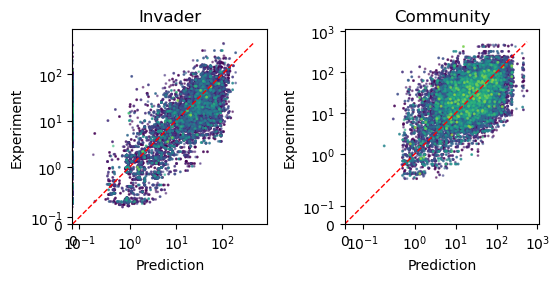

/var/folders/cv/1ryyrfz53_7g9k2dn5pwmtt40000gn/T/ipykernel_15462/303683615.py:71: UserWarning: Adding colorbar to a different Figure <Figure size 570x300 with 2 Axes> than <Figure size 100x300 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter0, cax=cbar_ax, label='Similarity Score')


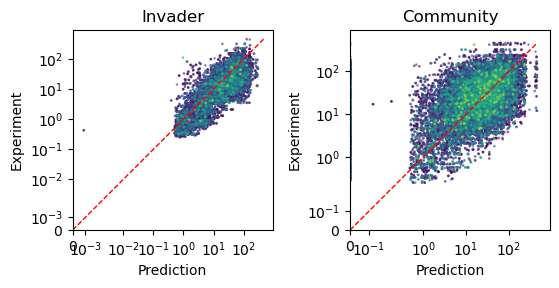

/var/folders/cv/1ryyrfz53_7g9k2dn5pwmtt40000gn/T/ipykernel_15462/303683615.py:71: UserWarning: Adding colorbar to a different Figure <Figure size 570x300 with 2 Axes> than <Figure size 100x300 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter0, cax=cbar_ax, label='Similarity Score')


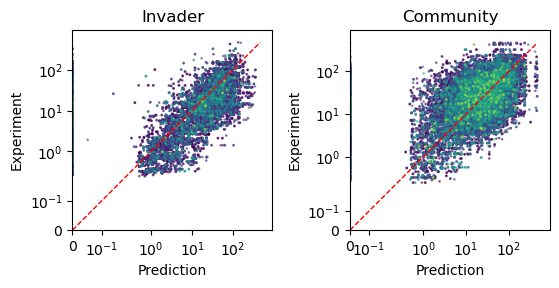

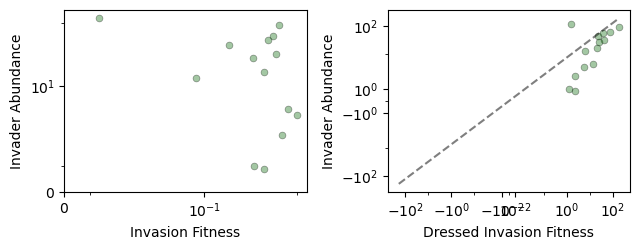

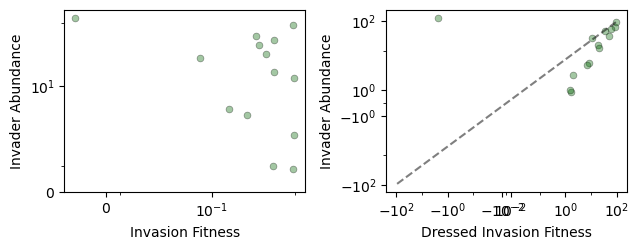

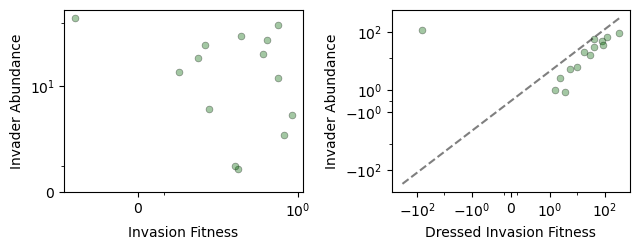

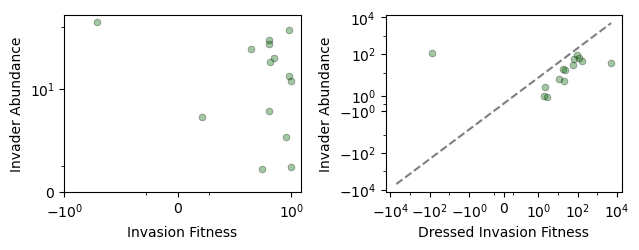

In [222]:
# Define the matrix directory
matrix_dir = '/Users/zhijie/Documents/GitHub/invasion-theory/additional_matrix'

# Define the data directory
data_dir = '/Users/zhijie/Documents/GitHub/invasion-theory/additional_data/biodiversity_II/organized_data'

data_dict = load_data(data_dir)
matrix_dict = load_matrix(matrix_dir)

#Get predictions 
for matrix_num in range(1,5):
    community_predicted_all, community_data_all, invader_predicted_all, invader_data_all, similarity_scores = predict_invasion_for_matrix(matrix_num, data_dict, matrix_dict,no_knock_off=True,similarity_threshold=0.85)
    plot_invader_community_one_invader_no_inset(invader_predicted_all, invader_data_all, community_predicted_all, community_data_all, similarity_scores, 'matrix'+str(matrix_num)+'_biodiversity_II_one_invader.pdf')
for matrix_num in range(1,5):
    community_predicted_all, community_data_all, invader_predicted_all, invader_data_all, similarity_scores = predict_invasion_for_matrix(matrix_num, data_dict, matrix_dict,no_knock_off=False,similarity_threshold=0.5)
    plot_invader_community_with_similarity(invader_predicted_all, invader_data_all, community_predicted_all, community_data_all, similarity_scores, 'matrix'+str(matrix_num)+'_biodiversity_II_similarity.pdf')

for matrix_num in range(1,5):
    invader_data_all, similarity_scores, invasion_fitnesses_all, dressed_invasion_fitnesses_all=get_fitness_for_matrix(matrix_num, data_dict, matrix_dict,no_knock_off=False,similarity_threshold=0.85)
    plot_invader_fitness_abundance(invader_data_all,invasion_fitnesses_all, dressed_invasion_fitnesses_all, 'matrix'+str(matrix_num)+'_biodiversity_II_one_invader_fitness_test.pdf')
    

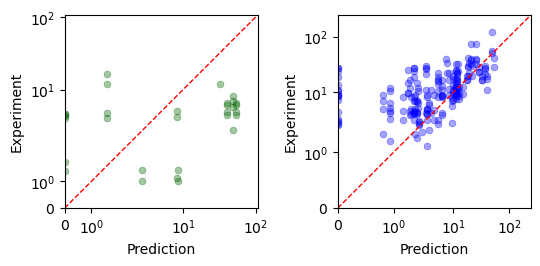

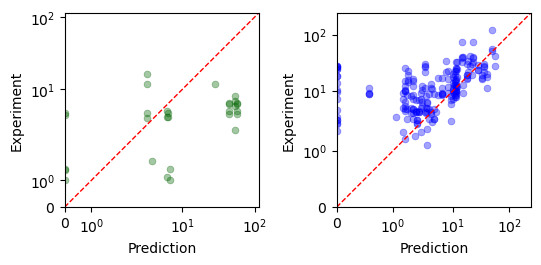

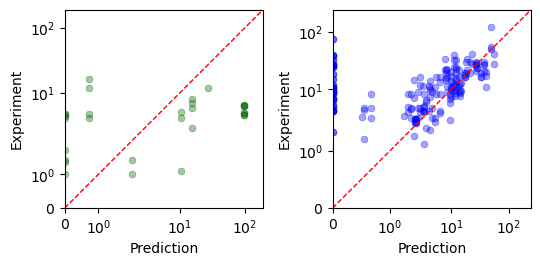

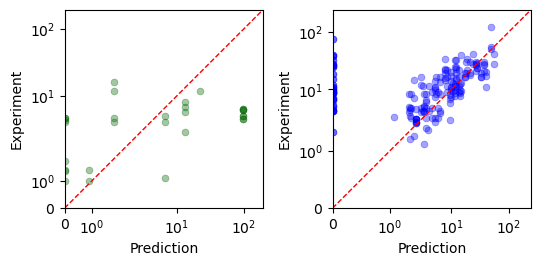

/var/folders/cv/1ryyrfz53_7g9k2dn5pwmtt40000gn/T/ipykernel_15462/303683615.py:71: UserWarning: Adding colorbar to a different Figure <Figure size 570x300 with 2 Axes> than <Figure size 100x300 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter0, cax=cbar_ax, label='Similarity Score')


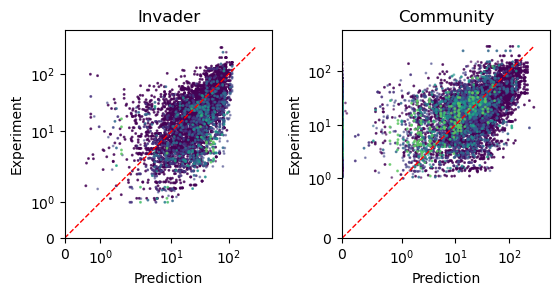

/var/folders/cv/1ryyrfz53_7g9k2dn5pwmtt40000gn/T/ipykernel_15462/303683615.py:71: UserWarning: Adding colorbar to a different Figure <Figure size 570x300 with 2 Axes> than <Figure size 100x300 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter0, cax=cbar_ax, label='Similarity Score')


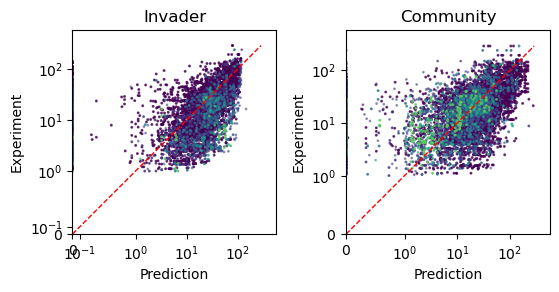

/var/folders/cv/1ryyrfz53_7g9k2dn5pwmtt40000gn/T/ipykernel_15462/303683615.py:71: UserWarning: Adding colorbar to a different Figure <Figure size 570x300 with 2 Axes> than <Figure size 100x300 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter0, cax=cbar_ax, label='Similarity Score')


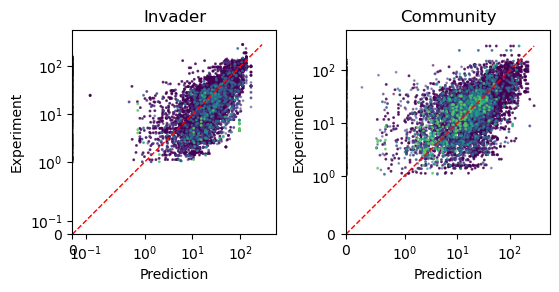

/var/folders/cv/1ryyrfz53_7g9k2dn5pwmtt40000gn/T/ipykernel_15462/303683615.py:71: UserWarning: Adding colorbar to a different Figure <Figure size 570x300 with 2 Axes> than <Figure size 100x300 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter0, cax=cbar_ax, label='Similarity Score')


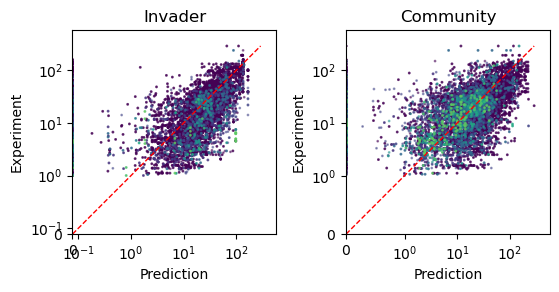

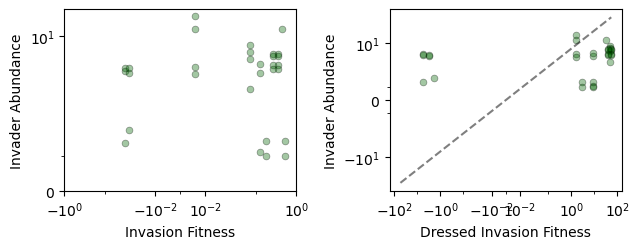

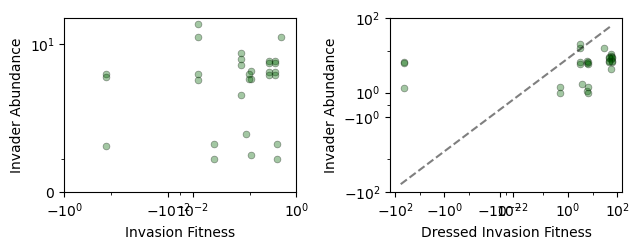

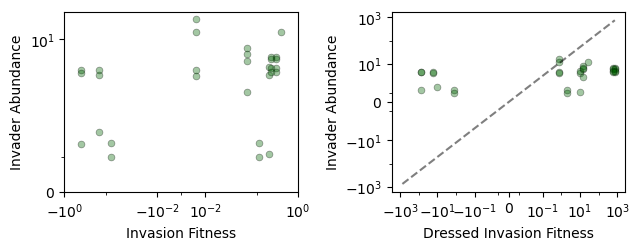

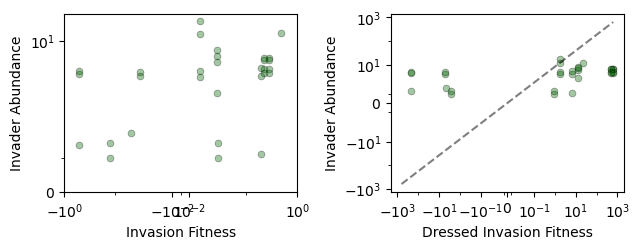

In [223]:
# Define the matrix directory
matrix_dir = '/Users/zhijie/Documents/GitHub/invasion-theory/additional_matrix'

# Define the data directory
data_dir = '/Users/zhijie/Documents/GitHub/invasion-theory/additional_data/van_ruijven/organized_data'

data_dict=load_data(data_dir)

matrix_dict=load_matrix(matrix_dir)

data_dict = load_data(data_dir)
matrix_dict = load_matrix(matrix_dir)

#Get predictions 
for matrix_num in range(1,5):
    community_predicted_all, community_data_all, invader_predicted_all, invader_data_all, similarity_scores = predict_invasion_for_matrix(matrix_num, data_dict, matrix_dict,no_knock_off=True,similarity_threshold=0.85)
    plot_invader_community_one_invader_no_inset(invader_predicted_all, invader_data_all, community_predicted_all, community_data_all, similarity_scores, 'matrix'+str(matrix_num)+'_van_ruijven_one_invader.pdf')

for matrix_num in range(1,5):
    community_predicted_all, community_data_all, invader_predicted_all, invader_data_all, similarity_scores = predict_invasion_for_matrix(matrix_num, data_dict, matrix_dict,no_knock_off=False,similarity_threshold=0.5)
    plot_invader_community_with_similarity(invader_predicted_all, invader_data_all, community_predicted_all, community_data_all, similarity_scores, 'matrix'+str(matrix_num)+'_van_ruijven_similarity.pdf')

for matrix_num in range(1,5):
    invader_data_all, similarity_scores, invasion_fitnesses_all, dressed_invasion_fitnesses_all=get_fitness_for_matrix(matrix_num, data_dict, matrix_dict,no_knock_off=False,similarity_threshold=0.85)
    plot_invader_fitness_abundance(invader_data_all,invasion_fitnesses_all, dressed_invasion_fitnesses_all, 'matrix'+str(matrix_num)+'_van_ruijven_one_invader_fitness_test.pdf')
    

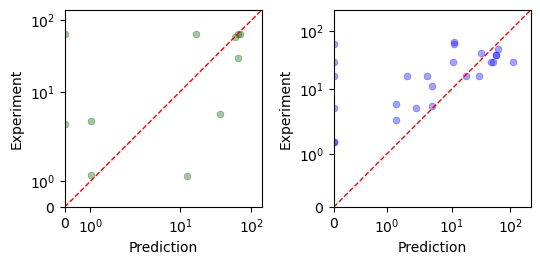

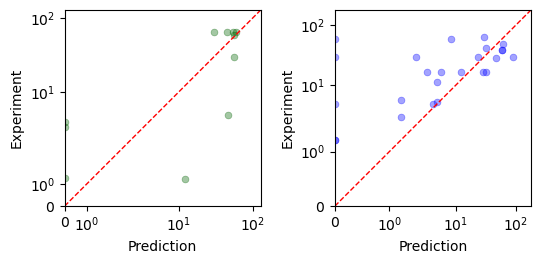

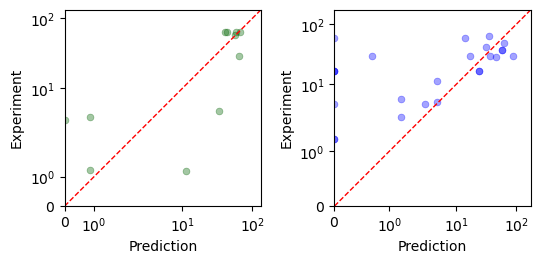

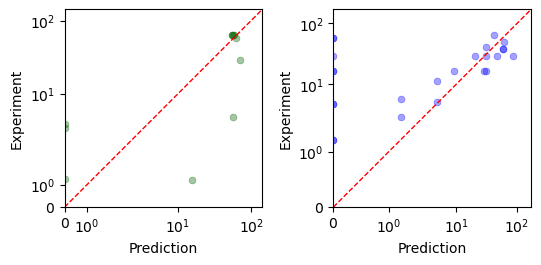

/var/folders/cv/1ryyrfz53_7g9k2dn5pwmtt40000gn/T/ipykernel_15462/303683615.py:71: UserWarning: Adding colorbar to a different Figure <Figure size 570x300 with 2 Axes> than <Figure size 100x300 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter0, cax=cbar_ax, label='Similarity Score')


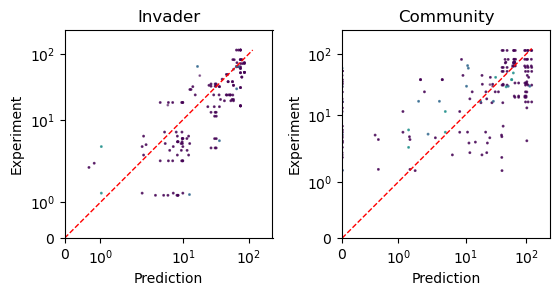

/var/folders/cv/1ryyrfz53_7g9k2dn5pwmtt40000gn/T/ipykernel_15462/303683615.py:71: UserWarning: Adding colorbar to a different Figure <Figure size 570x300 with 2 Axes> than <Figure size 100x300 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter0, cax=cbar_ax, label='Similarity Score')


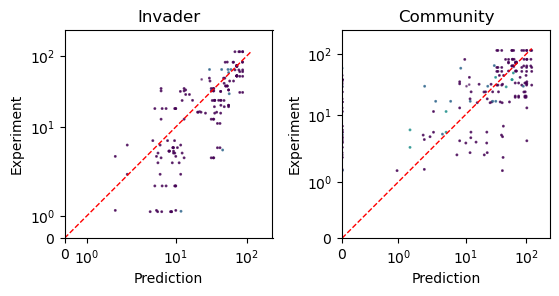

/var/folders/cv/1ryyrfz53_7g9k2dn5pwmtt40000gn/T/ipykernel_15462/303683615.py:71: UserWarning: Adding colorbar to a different Figure <Figure size 570x300 with 2 Axes> than <Figure size 100x300 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter0, cax=cbar_ax, label='Similarity Score')


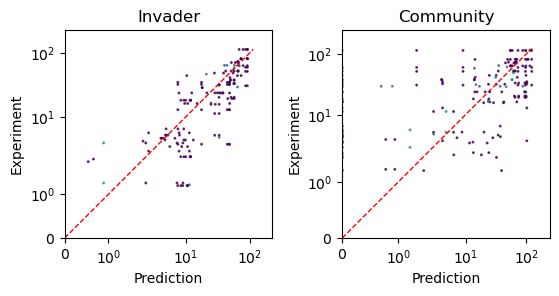

/var/folders/cv/1ryyrfz53_7g9k2dn5pwmtt40000gn/T/ipykernel_15462/303683615.py:71: UserWarning: Adding colorbar to a different Figure <Figure size 570x300 with 2 Axes> than <Figure size 100x300 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter0, cax=cbar_ax, label='Similarity Score')


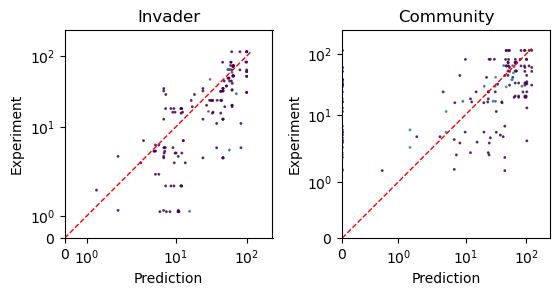

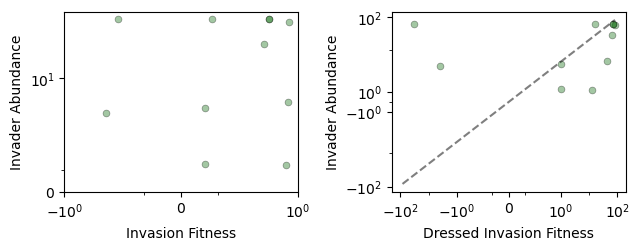

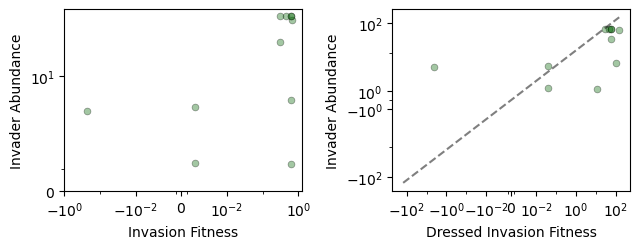

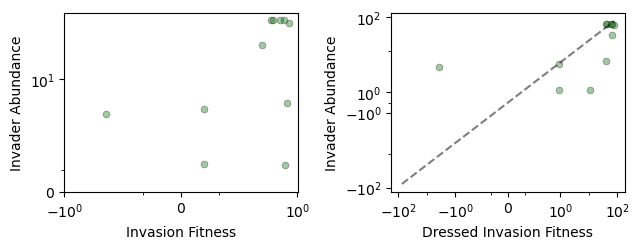

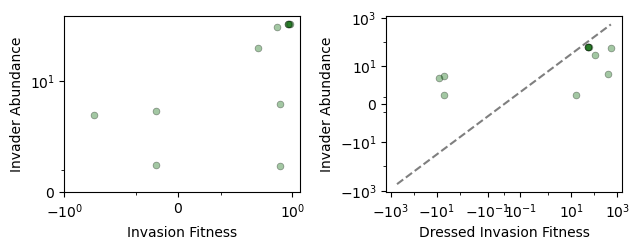

In [224]:
# Define the matrix directory
matrix_dir = '/Users/zhijie/Documents/GitHub/invasion-theory/additional_matrix'

# Define the data directory
data_dir = '/Users/zhijie/Documents/GitHub/invasion-theory/additional_data/cadotte_2013/organized_data'

data_dict=load_data(data_dir)

matrix_dict=load_matrix(matrix_dir)

data_dict = load_data(data_dir)
matrix_dict = load_matrix(matrix_dir)

# Get predictions 
for matrix_num in range(1,5):
    community_predicted_all, community_data_all, invader_predicted_all, invader_data_all, similarity_scores = predict_invasion_for_matrix(matrix_num, data_dict, matrix_dict,no_knock_off=False,similarity_threshold=0.6)
    plot_invader_community_one_invader_no_inset(invader_predicted_all, invader_data_all, community_predicted_all, community_data_all, similarity_scores, 'matrix'+str(matrix_num)+'_cadotte_2013_one_invader.pdf')

for matrix_num in range(1,5):
    community_predicted_all, community_data_all, invader_predicted_all, invader_data_all, similarity_scores = predict_invasion_for_matrix(matrix_num, data_dict, matrix_dict,no_knock_off=False,similarity_threshold=0.5)
    plot_invader_community_with_similarity(invader_predicted_all, invader_data_all, community_predicted_all, community_data_all, similarity_scores, 'matrix'+str(matrix_num)+'_cadotte_2013_similarity.pdf')

for matrix_num in range(1,5):
    invader_data_all, similarity_scores, invasion_fitnesses_all, dressed_invasion_fitnesses_all=get_fitness_for_matrix(matrix_num, data_dict, matrix_dict,no_knock_off=False,similarity_threshold=0.6)
    plot_invader_fitness_abundance(invader_data_all,invasion_fitnesses_all, dressed_invasion_fitnesses_all, 'matrix'+str(matrix_num)+'_cadotte_2013_one_invader_fitness_test.pdf')
    